### Tests
Use of the agglomerative clustering with HR diagram.

The dirty work is done in gaia_utils...

In [41]:
import sys, os
sys.path.append('../../src')


import matplotlib.pyplot as plt
from pylab import rcParams
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

from math import ceil
import gaia_utils as gu
from sklearn import cluster
from sklearn.neighbors import kneighbors_graph

%matplotlib inline

## directory
rootdir = "/home/stephane/Science/GAIA"
wdir    = "%s/products"%(rootdir)
datadir = "%s/master/notebooks/data"%(rootdir)

os.chdir(wdir)
rcParams['figure.figsize'] = 10, 10
###################################

clustername = "NGC 1039"
# voname = 'NGC 752-1.0deg.vot'
# voname = 'NGC 2682-3.0deg.vot'
voname = 'NGC 1039-3.0deg.vot'
RADIUS   = 3.0
kCluster = 9
votable_disk = False
distclust = 510.0
WEIGHT = [2.,2.,10.,5.,5., 2., 2., 2.]

## dscan
eps = 0.05
min_samples = 30
## Ward
neighbors = 30

In [42]:
## plot2D and plot3D


def plot2d(df, labels, ilab, cmap = "gist_stern" ,color = False):
    
    rcParams['figure.figsize'] = 14, 14
    f, axarr = plt.subplots(2, 2)
    
    if color:
        axarr[0,0].scatter(df[np.where(labels == ilab),0],df[np.where(labels == ilab),1],  s = 0.5, c= df[np.where(labels == ilab),2], cmap=cmap )
    else:
        axarr[0,0].scatter(df[np.where(labels == ilab),0],df[np.where(labels == ilab),1],  s = 0.5, c = "k")
    axarr[0,0].set_xlabel("l")
    axarr[0,0].set_ylabel("b")
    
    axarr[1,0].scatter(df[np.where(labels == ilab),0],df[np.where(labels == ilab),2] , s=0.5, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[1,0].set_xlabel("l")
    axarr[1,0].set_ylabel("d (pc)")
    
    
    axarr[0,1].scatter(df[np.where(labels == ilab),3],df[np.where(labels == ilab),4] , s= 0.5, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[0,1].set_xlabel("Vdra")
    axarr[0,1].set_ylabel("Vdec")
    
    axarr[1,1].scatter(df[np.where(labels == ilab),6],df[np.where(labels == ilab),5] , s = 0.5, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[1,1].set_xlabel("G-R")
    axarr[1,1].set_ylabel("G")
    axarr[1,1].set_xlim(-1.,1.5)
    axarr[1,1].set_ylim(27.,10)
    
    plt.show()
    

In [43]:
## astrometric conversion
## 
def convert_to_cartesian(lgal, bga, dist, offCenter = [0., 0.]):
    "Convert ra,dec (ICRS) and distance (pc) to Cartesian reference. Off is the offset in Lgal,Bgal"
    
    xx = np.zeros(len(lgal))
    yy = np.zeros(len(lgal))
    zz = np.zeros(len(lgal))
    
    lgalOff = lgal - offCenter[0]
    bgalOff = bgal - offCenter[1]
    
    print(offCenter[0])
    print(offCenter[1])
    print(min(lgalOff))
    print(max(lgalOff))
    print(min(bgalOff))
    print(max(bgalOff))
    
    
    for i in range(len(lgal)):
        c = coord.SkyCoord(l=lgalOff[i]*u.degree, b=bgalOff[i]*u.degree, distance=dist[i]*u.pc, frame='galactic')
        
        xx[i] = c.cartesian.x.value
        yy[i] = c.cartesian.y.value
        zz[i] = c.cartesian.z.value
        
    print("## XX")
    print("min, max: %f , %f"%(min(xx),max(xx)))
    print("## YY")
    print("min, max: %f , %f"%(min(yy),max(yy)))
    print("## ZZ")
    print("min, max: %f , %f"%(min(zz),max(zz)))  
        
    return(xx,yy,zz)

In [44]:
## Read the data and do the conversion


source = gu.source(clustername)
source.weight = WEIGHT
source.query(RADIUS, errtol = 0.1, dump = True)
#source.read_votable(voname)
source.convert_filter_data()
source.normalization_normal()
# source.normalization_minmax(mag_range = [-10., 40.])

SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',40.5208000000,42.7617000000,3.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.100000  AND abs(pmdec_error/pmdec)< 0.1000000000 AND abs(parallax_error/parallax)< 0.1000000000;
Launched query: 'SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',40.5208000000,42.7617000000,3.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.100000  AND abs(pmdec_error/pmdec)< 0.1000000000 AND abs(parallax_error/parallax)< 0.1000000000;'
Retrieving async. results...
## NGC 1039-3.0deg.vot created
## Query for NGC 1039 done
## Total stars: 30131
## Conversion done...
## Stars selected: 29334
## Normalization done on filtered data..


()

### Some plotting ...

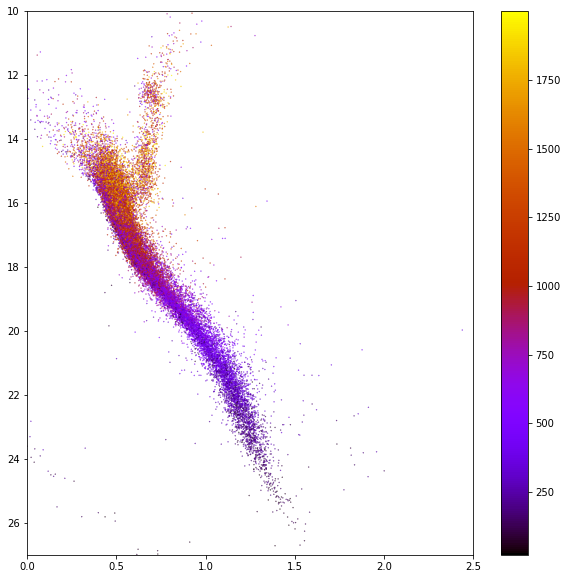

In [45]:
plt.scatter(source.df[:,6], source.df[:,5], s= 0.1, c=source.df[:,2], cmap='gnuplot')
plt.colorbar()
plt.xlim([0.,2.5])
plt.ylim([27.,10])
plt.show()


### Clustering

In [46]:
print("## k-means...")

# KMeans for each normalisation
kmeans = cluster.KMeans(n_clusters= kCluster, max_iter = 2000, n_init = 50)
kmeans.fit(source.dfnorm)
labels_k = kmeans.labels_
for i in range(kCluster):
    print("# Label %5d : %5d  Dist: %5.1f"%(i,len(labels_k[np.where(labels_k == i)]), np.median(source.df[np.where(labels_k == i),2])))
print("##")

###########
print("## Ward... ")
# connectivity matrix for structured Ward

connectivity = kneighbors_graph(source.dfnorm, n_neighbors= neighbors, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

ward = cluster.AgglomerativeClustering(n_clusters= kCluster, linkage='ward', connectivity=connectivity)
ward.fit(source.dfnorm)
labels_w = ward.labels_
for i in range(kCluster):
    print("# Label %5d : %5d  Dist: %5.1f"%(i,len(labels_w[np.where(labels_w == i)]), np.median(source.df[np.where(labels_w == i),2])))
print("##")
    
############# 
print("## Spectral...")
spectral = cluster.SpectralClustering(n_clusters = kCluster, eigen_solver='arpack', affinity="nearest_neighbors")
spectral.fit(source.dfnorm)
labels_s = spectral.labels_
for i in range(kCluster):
    print("# Label %5d : %5d  Dist: %5.1f"%(i,len(labels_s[np.where(labels_s == i)]), np.median(source.df[np.where(labels_s == i),2])))
print("##")


############# 
print("## DBSCAN...")
dbscan = cluster.DBSCAN(eps, min_samples)
dbscan.fit(source.dfnorm)
labels_d = spectral.labels_
for i in range(max(labels_d)):
    print("# Label %5d : %5d  Dist: %5.1f"%(i,len(labels_d[np.where(labels_d == i)]), np.median(source.df[np.where(labels_d == i),2])))
print("##")


## k-means...
# Label     0 :  3769  Dist: 1104.3
# Label     1 :  4331  Dist: 565.4
# Label     2 :  3532  Dist: 1630.1
# Label     3 :  5336  Dist: 304.7
# Label     4 :  2256  Dist: 1026.1
# Label     5 :  3050  Dist: 1225.8
# Label     6 :  1844  Dist: 480.8
# Label     7 :   134  Dist: 453.2
# Label     8 :  5082  Dist: 762.1
##
## Ward... 
# Label     0 :  4399  Dist: 632.4
# Label     1 :  2521  Dist: 1019.8
# Label     2 :  6882  Dist: 340.0
# Label     3 :  3240  Dist: 1318.4
# Label     4 :   134  Dist: 453.2
# Label     5 :  3113  Dist: 1650.7
# Label     6 :  3482  Dist: 664.9
# Label     7 :  3245  Dist: 955.1
# Label     8 :  2318  Dist: 1058.5
##
## Spectral...
# Label     0 :  2534  Dist: 524.8
# Label     1 :  6733  Dist: 346.3
# Label     2 :  3853  Dist: 1238.6
# Label     3 :  1805  Dist: 1212.6
# Label     4 :  1458  Dist: 1569.5
# Label     5 :  6520  Dist: 750.7
# Label     6 :   134  Dist: 453.2
# Label     7 :  1399  Dist: 1705.9
# Label     8 :  4898  Dist: 88

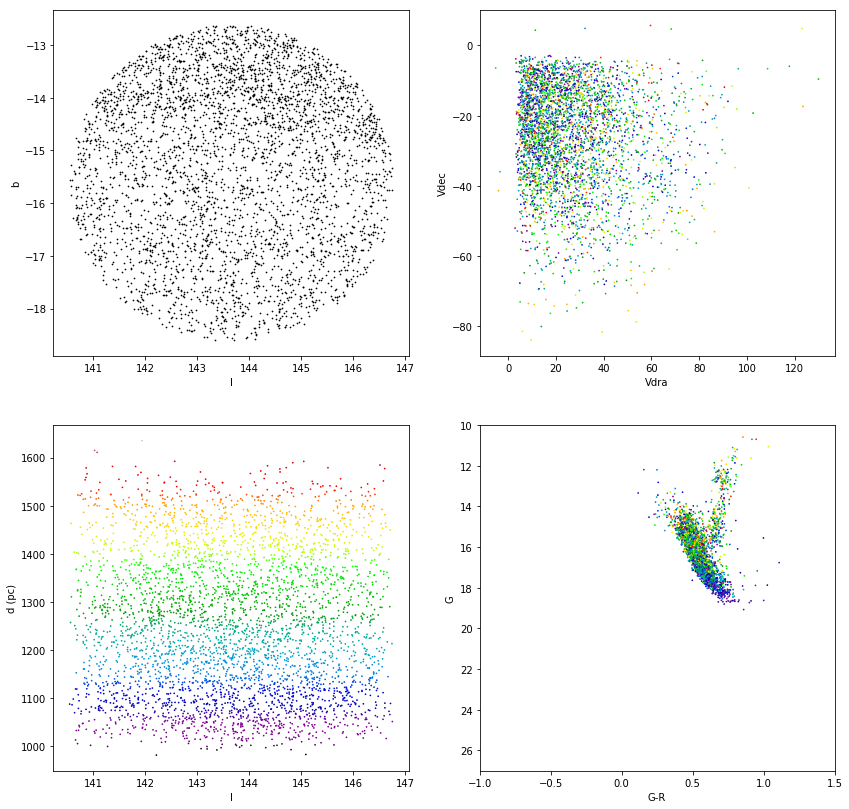

In [47]:
plot2d(source.df, labels_d, 2, cmap = "nipy_spectral")